# Post-processing
This notebook presents the methods that were used to get more insight about the predictions made by our best model.

### Importing the needed packages

In [1]:
import pandas as pd
import csv
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np
import torch

The first step consists of loading the pre-trained model. Some small adjustments have to made as some attributes were added to the model after the training (`self.is_lstm`).

In [2]:
# Select available device
device = ('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model and ensure compatibility
model = torch.load('../models/GRUNet', map_location=device)
model.device = device
model.is_lstm = False

The [Glove](https://nlp.stanford.edu/projects/glove/) word embedding is well known for mapping sementically close terms close to each other in the embedding space. Since we allowed fine tuning of the embedding matrix during the training process we want to make sure that this property is still valid afterwards. To that purpose we load the fine-tuned embedding matrix and the corresponding word indexer. We further implemented some methods that allows the retrieval of the k-nearest neighbours of a given word using the euclidian distance. 

In [3]:
# Load the embedding matrix and word indexer
embedding_values_model = model.embedding.weight.detach().numpy()
word_to_index = model.word_indexer
index_to_word = dict(zip(word_to_index.values(), word_to_index.keys()))

In [4]:
def compute_closest_words(word, embedding_values, word_to_index, index_to_word, kth):
    """
    computes the k-nearest neighbours of a given word using euclidian distance
    @param word: single word as a string
    @param embedding_values: pre-trained embedding matrix
    @param word_to_index: dictionary from word to row in embedding matrix
    @param index_to_word: dictionary from row in embedding matrix to word
    @param kth: number of neighbours to return
    @return: list of tuples (word, word index)
    """
    word_embedding = embedding_values[word_to_index[word]]
    closest_indexes = np.argpartition(np.sum(np.power(embedding_values - word_embedding, 2), axis=1), kth=kth)
    return list(map(lambda index: index_to_word[index], closest_indexes[0:kth]))

In [5]:
def sentiment(prediction):
    """
    @param prediction: output of the model as a tensor
    @return: string describing the associated sentiment to the prediction
    """
    prediction = torch.argmax(prediction).item()
    if prediction:
        return 'positive'
    return 'negative'

def word_group_predictions(word, embedding_values, word_to_index, index_to_word, kth, model):
    """
    computes the k-nearest neighbours of a given word using euclidian distance
    @param word: single word as a string
    @param embedding_values: pre-trained embedding matrix
    @param word_to_index: dictionary from word to row in embedding matrix
    @param index_to_word: dictionary from row in embedding matrix to word
    @param kth: number of neighbours to return
    @param model: pre-trained model used for predictions
    @return: dictionary of {word: sentiment}
    """
    group_words = compute_closest_words(word, embedding_values, word_to_index, index_to_word, kth)
    group_preds = list(map(lambda word: sentiment(model([word])), group_words))
    return dict(zip(group_words, group_preds))

Since the overall goal of this project is sentiment analysis we chose to which of the words are typically associated with a positive/negative sentiment.  

In [6]:
word_group_predictions('happy', embedding_values_model, word_to_index, index_to_word, 10, model)

{'happy': 'positive',
 'hello': 'positive',
 'lovely': 'positive',
 'birthday': 'positive',
 'nice': 'positive',
 'goodnight': 'positive',
 'welcome': 'positive',
 'love': 'positive',
 'enjoy': 'positive',
 'good': 'positive'}

In [7]:
word_group_predictions('sad', embedding_values_model, word_to_index, index_to_word, 10, model)

{'sad': 'negative',
 'hate': 'negative',
 'ugh': 'negative',
 'lonely': 'negative',
 'sigh': 'negative',
 'sick': 'negative',
 'cry': 'negative',
 'upset': 'negative',
 'scary': 'negative',
 'shame': 'negative'}

Fortunately we observe that the k-nearest neighbours of the chosen words ('happy' and 'sad') are sementically close and are further predicted to bear the same sentiment by our model.

### Assessing the model's performance
The performance of the model can be assessed by feeding it with some unseen data. 

In [8]:
def predict_tweets(model, test_data, batch_size=100):
    """
    @param model: pre-trained model
    @param test_data: clean and unseen data
    @param batch_size: batch size
    @return: predictions of the pre-trained model on the test data
    """
    test_tweet = test_data['tweet']
    predictions = []

    # Iterate over test data
    for i in range(int(test_tweet.shape[0] / batch_size)):
        batch_text = test_tweet.iloc[i * batch_size:(i + 1) * batch_size]
        batch_prediction = model.forward(batch_text)
        predictions.append(batch_prediction)

    predictions = torch.cat(predictions)
    predictions = torch.argmax(predictions, dim=1)
    return predictions

In [9]:
# Load the clean test data
test_data = pd.read_csv('../Data/test_full.txt')
test_data = test_data.sample(10000)
test_data['prediction'] = predict_tweets(model, test_data)

In [10]:
print('Precision: {0:.3f}'.format(precision_score(test_data['label'], test_data['prediction'])))
print('Recall: {0:.3f}'.format(recall_score(test_data['label'], test_data['prediction'])))

Precision: 0.823
Recall: 0.870


We observe a significant discrepancy between the precision score and the recall score. From the above observation we can state that the model tends to classify too many sample as positive. A possible reason could be the [inability of our model to understand sarcasm.](http://healthland.time.com/2011/04/15/failure-to-detect-sarcasm-or-lies-a-sign-of-a-rare-dementia/)

### Clustering the embedding
We previously observed that sementcally similar words were mapped close to each other in the embedding space, which suggest that an supervised clustering on the embedding space could be meaningful. To this end, we ran the k-means algorithm on the embedding space.

In [28]:
n_clusters = 100
km = KMeans(
    n_clusters=n_clusters, init='k-means++',
)
y_km = km.fit_predict(embedding_values_model)

To get a good representation of the different clusters we select for each of them the samples that are the closest to the centroid. Note that this can be done using the euclidian distance as the KMeans algorithm classifies the samples assuming a diagonal covariance matrix. If we were using GMM instead, the appropriate distance metric would have been different.

In [31]:
def compute_best_assignments(kmeans, assignments, embedding_values, index_to_word, kth):
    """
    find the k closest words to each centroid
    @param kmeans: pre-trained k-means model
    @param assignments: per sample cluster assignment
    @param embedding_values: pre-trained embedding matrix
    @param index_to_word: dictionary from row in embedding matrix to word
    @param kth: number of neighbours per centroid
    @return: dictionary from centroid to k closest words and all selected words as row in embedding matrix
    """
    top_assignments = dict()
    top_indexes = []
    for i, assignment in enumerate(np.unique(assignments)):
        closest_indexes = np.argpartition(np.sum(np.power(embedding_values - kmeans.cluster_centers_[i],
                                                          2), axis=1), kth=kth)
        top_indexes.append(closest_indexes[0:kth])
        top_assignments[i] = list(map(lambda index: index_to_word[index], closest_indexes[0:kth]))
    return top_assignments, np.stack(top_indexes).flatten()

In [32]:
best_asssignments, best_indexes = compute_best_assignments(km, y_km, embedding_values_model, index_to_word, 50)

We can further assess the performance of the clustering by using the [TSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) library which maps the 25 dimensional embedding space to a 2 dimensional space which can then be observed.

In [33]:
# Run TSNE to map the 25d embedding space to a new 2d space
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(embedding_values_model[best_indexes])

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.007s...
[t-SNE] Computed neighbors for 5000 samples in 1.292s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.073544
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.718872
[t-SNE] KL divergence after 1000 iterations: 1.197512


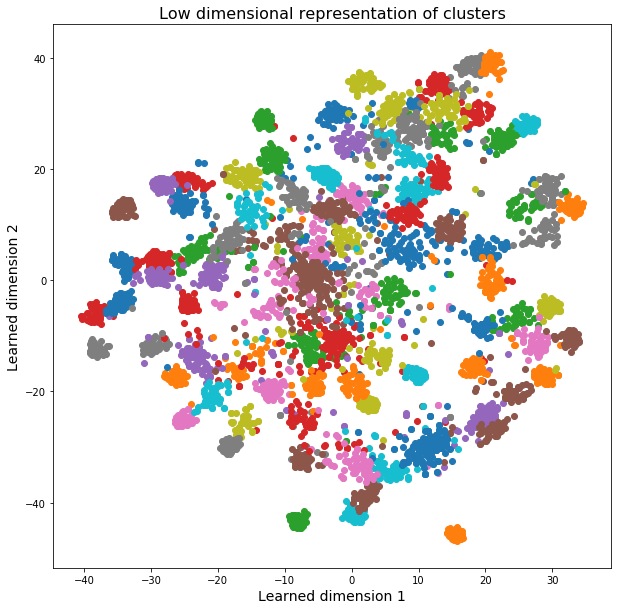

In [35]:
# Plot the clustering samples
fig = plt.subplots(figsize=(10, 10))
for cluster in range(n_clusters):
    plt.scatter(tsne_results[y_km[best_indexes] == cluster, 0], 
                tsne_results[y_km[best_indexes] == cluster, 1], label='cluster: {}'.format(cluster))
    plt.title('Low dimensional representation of clusters', fontsize=16)
    plt.xlabel('Learned dimension 1', fontsize=14)
    plt.ylabel('Learned dimension 2', fontsize=14)

The above plot displays some kind of clustering, nonetheless it should be taken with a grain of salt as some subsampling occurred before the 2 dimensional mapping. The plot without subsampling is much more cluttered and does not show strict boundaries between clusters. The latter observation is coherent with the intuition that some word might belong to more than one cluster. For instance 'cuz' (because) should probably be part of the 'slang' cluster but also the 'conjunction' cluster. A quick selection of the best clusters observed: <br>
   - French (20)
   - Adverb (23)
   - Time (30)
   - Medical (31)
   - Actors/Fictional characters (57)
   - Food cluster (60)
   - Movies/Bands cluster (16)

In [196]:
clusters_df = pd.DataFrame()
clusters_df['French'] = best_asssignments[20]
clusters_df['Adverb'] = best_asssignments[23]
clusters_df['Time'] = best_asssignments[30]
clusters_df['Medical'] = best_asssignments[31]
clusters_df['Actors/Characters'] = best_asssignments[57]
clusters_df['Food'] = best_asssignments[60]
clusters_df['Movies/Bands'] = best_asssignments[16]

In [198]:
# A small selection of meaningful clsuters
clusters_df

,French,Adverb,Time,Medical,Actors/Characters,Food,Movies/Bands
0,meme,presumably,tmrr,buildup,gyllenhaal,sour,fable
1,lieu,creatively,tmra,inflammation,odell,crackers,gaslight
2,esprit,virtually,bitchezz,melanoma,crowe,scotch,banshee
3,cul,completly,dox,humiliation,kidman,veggie,highlander
4,complet,unnecessarily,tomorra,breakage,haim,crispy,gnr
5,malin,outrageously,toniight,deafness,fassbender,munch,daredevil
6,mur,admittedly,saterday,maneuver,farley,froyo,rdr
7,signe,predictably,tomarro,affirmative,sybil,muffin,tgp
8,voila,slighty,shesh,backlog,alonzo,tart,dancefloor
9,pere,similarly,tomorroe,schizophrenia,ginny,nugget,firefly
